In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import math
np.random.seed(0)

In [ ]:
# -------------------------
# Helper functions
# -------------------------
def multivariate_gaussian(x, mean, cov):
    """
    Compute multivariate Gaussian density for each row in x.
    x: (N, d)
    mean: (d,)
    cov: (d, d)
    returns: (N,) densities
    """
    d = mean.shape[0]
    x_mu = x - mean
    # regularization handled outside
    try:
        cov_inv = np.linalg.inv(cov)
    except np.linalg.LinAlgError:
        # fallback: add small noise
        cov_inv = np.linalg.inv(cov + 1e-6 * np.eye(d))
    det = np.linalg.det(cov)
    denom = np.sqrt(((2*np.pi)**d) * det)
    exp_term = np.einsum('ij,jk,ik->i', x_mu, cov_inv, x_mu)
    return (1.0 / denom) * np.exp(-0.5 * exp_term)

def plot_gmm(X, responsibilities, mus, covs, title=''):
    """
    Plot clustered data with ellipses for covariances.
    responsibilities: (N, K)
    mus: list of K (d,) arrays
    covs: list of K (d,d) arrays
    """
    N, d = X.shape
    K = responsibilities.shape[1]
    labels = responsibilities.argmax(axis=1)
    colors = ['C'+str(i) for i in range(K)]
    plt.figure(figsize=(8,6))
    for k in range(K):
        pts = X[labels == k]
        plt.scatter(pts[:,0], pts[:,1], s=15, alpha=0.6, label=f'comp {k}')
        # plot mean
        plt.scatter(mus[k][0], mus[k][1], marker='x', c=colors[k], s=100)
        # plot ellipse
        plot_cov_ellipse(covs[k], mus[k])
    plt.title(title)
    plt.legend()
    plt.xlabel('x1'); plt.ylabel('x2')
    plt.grid(True)
    plt.show()

def plot_cov_ellipse(cov, pos, nstd=2.0, ax=None):
    """
    Plot an ellipse representing the covariance matrix cov centered at pos.
    nstd: number of standard deviations (radius)
    """
    if ax is None:
        ax = plt.gca()
    # Eigenvalues and eigenvectors
    vals, vecs = np.linalg.eigh(cov)
    # Sort by largest eigenvalue
    order = vals.argsort()[::-1]
    vals = vals[order]
    vecs = vecs[:, order]
    theta = np.degrees(np.arctan2(vecs[1,0], vecs[0,0]))
    width, height = 2 * nstd * np.sqrt(np.abs(vals))
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, alpha=0.2)
    ax.add_patch(ellip)


In [ ]:
# -------------------------
# EM algorithm (from scratch)
# -------------------------
def run_em_gmm(X, K, max_iters=100, tol=1e-6, init_method='kmeans', reg_covar=1e-6, verbose=False):
    """
    Run EM for GMM.
    X: (N,d)
    K: number of components
    Returns parameters and log_likelihood history and responsibilities
    """
    N, d = X.shape
    # Initialization
    if init_method == 'kmeans':
        km = KMeans(n_clusters=K, n_init=10, random_state=0).fit(X)
        mus = km.cluster_centers_
        labels = km.labels_
        covs = []
        pis = np.zeros(K)
        for k in range(K):
            pts = X[labels == k]
            if pts.shape[0] == 0:
                covs.append(np.cov(X.T) + reg_covar * np.eye(d))
                pis[k] = 1.0 / K
            else:
                covs.append(np.cov(pts.T) + reg_covar * np.eye(d))
                pis[k] = float(pts.shape[0]) / N
        pis = pis / pis.sum()
    else:  # random init
        # random means from data
        idx = np.random.choice(N, K, replace=False)
        mus = X[idx].copy()
        covs = [np.cov(X.T) + reg_covar * np.eye(d) for _ in range(K)]
        pis = np.ones(K) / K

    log_likelihoods = []
    responsibilities = np.zeros((N, K))

    for it in range(max_iters):
        # E-step: compute responsibilities
        for k in range(K):
            responsibilities[:, k] = pis[k] * multivariate_gaussian(X, mus[k], covs[k])
        # numeric stabilization
        row_sums = responsibilities.sum(axis=1, keepdims=True)
        # Avoid division by zero
        row_sums[row_sums == 0] = 1e-12
        responsibilities /= row_sums

        # M-step: update parameters
        N_k = responsibilities.sum(axis=0)  # shape (K,)
        # Update pis
        pis = N_k / N
        # Update means
        mus = np.dot(responsibilities.T, X) / N_k[:, np.newaxis]  # (K, d)
        # Update covariances
        covs = []
        for k in range(K):
            diff = X - mus[k]  # (N, d)
            weighted = diff.T * responsibilities[:, k]  # (d, N) broadcast
            cov_k = (weighted @ diff) / (N_k[k] + 1e-12)
            # regularize
            cov_k += reg_covar * np.eye(d)
            covs.append(cov_k)

        # Compute log-likelihood
        log_prob = np.zeros((N, K))
        for k in range(K):
            log_prob[:, k] = np.log(pis[k] + 1e-12) + np.log(multivariate_gaussian(X, mus[k], covs[k]) + 1e-12)
        # log-sum-exp for stability
        max_log = np.max(log_prob, axis=1, keepdims=True)
        ll = np.sum(max_log + np.log(np.sum(np.exp(log_prob - max_log), axis=1, keepdims=True)))
        log_likelihoods.append(ll)

        if verbose:
            print(f"Iter {it+1}, log-likelihood: {ll:.6f}")

        # check convergence
        if it > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            if verbose:
                print("Converged at iter", it+1)
            break

    # Compute final responsibilities one more time (stable)
    responsibilities = np.zeros((N, K))
    for k in range(K):
        responsibilities[:, k] = pis[k] * multivariate_gaussian(X, mus[k], covs[k])
    responsibilities /= responsibilities.sum(axis=1, keepdims=True)

    return {
        'pis': pis,
        'mus': np.array(mus),
        'covs': covs,
        'responsibilities': responsibilities,
        'log_likelihoods': log_likelihoods
    }

Iter 1, log-likelihood: -2322.922447
Iter 2, log-likelihood: -2322.920719
Iter 3, log-likelihood: -2322.920647
Iter 4, log-likelihood: -2322.920644
Converged at iter 4


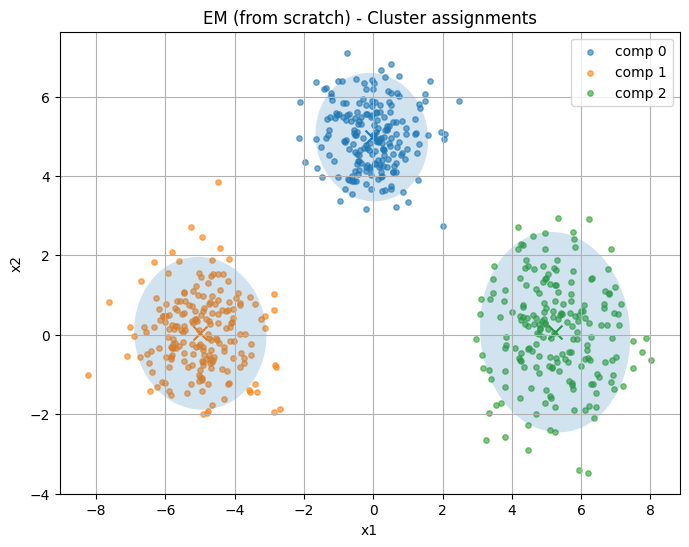

In [ ]:
# -------------------------
# Example: synthetic data
# -------------------------
# Generate synthetic 2D data with 3 clusters
X, y_true = make_blobs(n_samples=600, centers=[(-5,0),(0,5),(5,0)], cluster_std=[1.0, 0.8, 1.2], random_state=42)

# Shuffle
perm = np.random.permutation(len(X))
X = X[perm]
y_true = y_true[perm]

# Run EM from scratch
K = 3
res_em = run_em_gmm(X, K=K, max_iters=200, tol=1e-5, init_method='kmeans', reg_covar=1e-6, verbose=True)

# Plot results
plot_gmm(X, res_em['responsibilities'], res_em['mus'], res_em['covs'], title='EM (from scratch) - Cluster assignments')


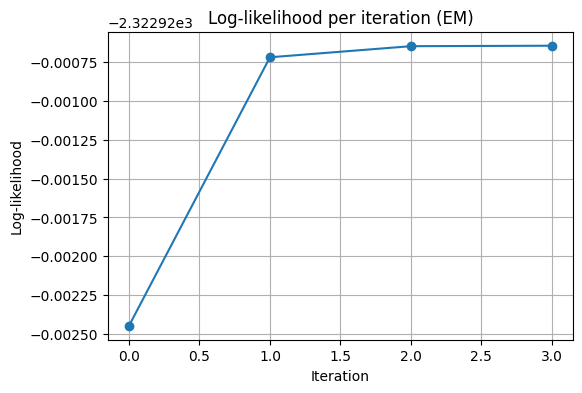

In [ ]:
# Plot log-likelihood curve
plt.figure(figsize=(6,4))
plt.plot(res_em['log_likelihoods'], marker='o')
plt.title('Log-likelihood per iteration (EM)')
plt.xlabel('Iteration'); plt.ylabel('Log-likelihood')
plt.grid(True)
plt.show()


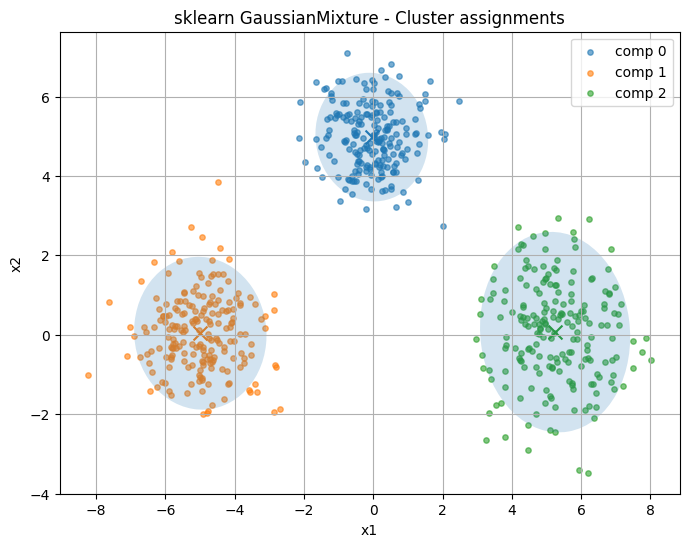

In [ ]:

# Compare with sklearn GaussianMixture
gmm = GaussianMixture(n_components=K, covariance_type='full', random_state=0, n_init=5).fit(X)
resp_sklearn = gmm.predict_proba(X)
mus_sk = gmm.means_
covs_sk = gmm.covariances_

plot_gmm(X, resp_sklearn, mus_sk, covs_sk, title='sklearn GaussianMixture - Cluster assignments')

In [ ]:

# Print final parameters comparison (means)
print("Means estimated (from scratch):")
print(res_em['mus'])
print("\nMeans estimated (sklearn):")
print(mus_sk)



Means estimated (from scratch):
[[-0.04216769  4.98020518]
 [-4.99365861  0.0387477 ]
 [ 5.24960156  0.06645376]]

Means estimated (sklearn):
[[-0.04202485  4.98004947]
 [-4.99365861  0.03874766]
 [ 5.24983052  0.06626433]]


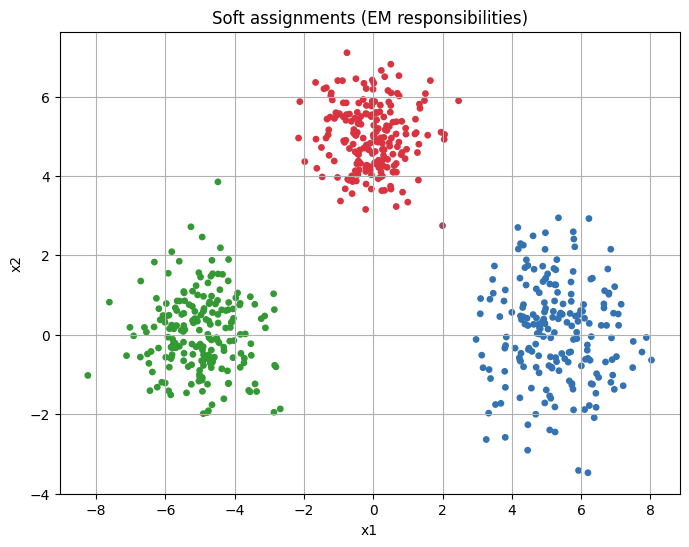

In [ ]:

# OPTIONAL: visualize responsibilities as soft colors
plt.figure(figsize=(8,6))
# color by weighted sum of RGB per component for a soft blend (for visualization)
colors_map = np.array([[0.85,0.2,0.25],[0.2,0.6,0.2],[0.2,0.45,0.7]])
soft_colors = res_em['responsibilities'] @ colors_map
plt.scatter(X[:,0], X[:,1], c=soft_colors, s=15)
plt.title('Soft assignments (EM responsibilities)')
plt.xlabel('x1'); plt.ylabel('x2')
plt.grid(True)
plt.show()

Converged at iteration: 5


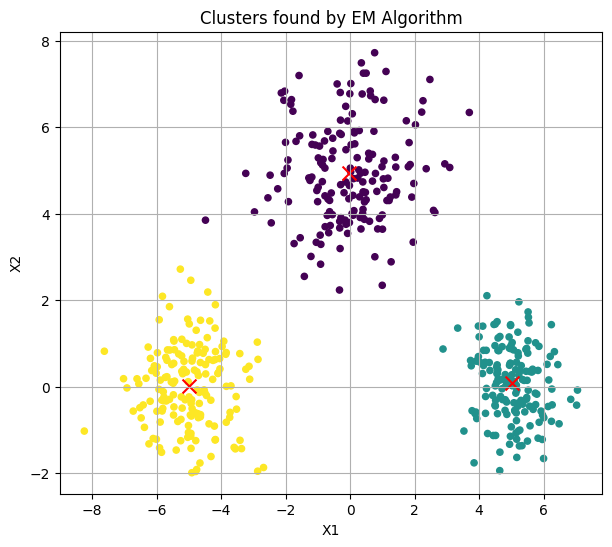

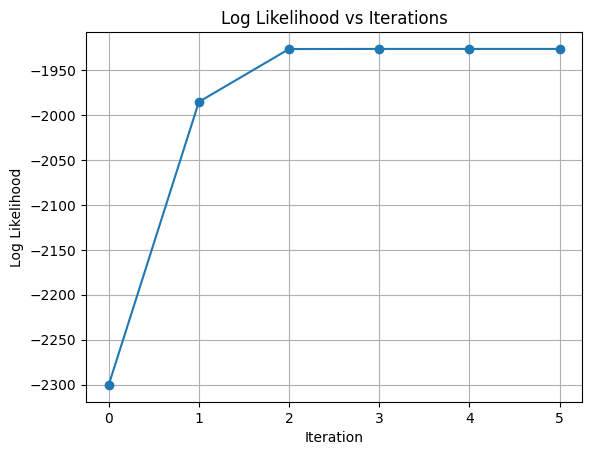

Means from my EM implementation:
 [[-0.03721297  4.94665788]
 [ 5.01998112  0.08903106]
 [-5.00484244  0.01400392]]

Means from sklearn GaussianMixture:
 [[-0.03619124  4.94693735]
 [ 5.01998116  0.08903138]
 [-5.00471636  0.01487238]]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# Function to calculate multivariate normal pdf
def gaussian_prob(x, mean, cov):
    n = x.shape[1]
    diff = x - mean
    inv_cov = np.linalg.inv(cov)
    det_cov = np.linalg.det(cov)
    norm_const = 1.0 / (np.power((2*np.pi), n/2) * np.sqrt(det_cov))
    exp_term = np.exp(-0.5 * np.sum(diff @ inv_cov * diff, axis=1))
    return norm_const * exp_term

# EM algorithm implementation
def em_gmm(X, k, max_iter=100, tol=1e-4):
    n, d = X.shape

    # ----- Initialization -----
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
    means = kmeans.cluster_centers_
    covs = [np.cov(X.T) for _ in range(k)]
    weights = np.ones(k) / k

    log_likelihoods = []

    for it in range(max_iter):
        # ----- E-step -----
        resp = np.zeros((n, k))
        for i in range(k):
            resp[:, i] = weights[i] * gaussian_prob(X, means[i], covs[i])
        resp = resp / resp.sum(axis=1, keepdims=True)

        # ----- M-step -----
        Nk = resp.sum(axis=0)
        weights = Nk / n

        for i in range(k):
            means[i] = np.sum(resp[:, i].reshape(-1,1) * X, axis=0) / Nk[i]
            diff = X - means[i]
            covs[i] = (resp[:, i].reshape(-1,1) * diff).T @ diff / Nk[i]
            covs[i] += 1e-6 * np.eye(d)  # small regularization term

        # ----- Compute log-likelihood -----
        ll = 0
        for i in range(k):
            ll += weights[i] * gaussian_prob(X, means[i], covs[i])
        log_likelihood = np.sum(np.log(ll + 1e-10))
        log_likelihoods.append(log_likelihood)

        # Check convergence
        if it > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            print("Converged at iteration:", it)
            break

    return means, covs, weights, resp, log_likelihoods

# Generate synthetic data
X, y = make_blobs(n_samples=500, centers=[(-5,0), (0,5), (5,0)], cluster_std=[1.0, 1.2, 0.8], random_state=42)

# Run EM algorithm
k = 3
means, covs, weights, resp, log_likelihoods = em_gmm(X, k)

# ----- Visualization -----
labels = np.argmax(resp, axis=1)
plt.figure(figsize=(7,6))
plt.scatter(X[:,0], X[:,1], c=labels, cmap='viridis', s=20)
plt.scatter(means[:,0], means[:,1], c='red', marker='x', s=100)
plt.title("Clusters found by EM Algorithm")
plt.xlabel("X1")
plt.ylabel("X2")
plt.grid(True)
plt.show()

# Plot log-likelihood
plt.figure()
plt.plot(log_likelihoods, marker='o')
plt.title("Log Likelihood vs Iterations")
plt.xlabel("Iteration")
plt.ylabel("Log Likelihood")
plt.grid(True)
plt.show()

# Compare with sklearn GaussianMixture
gmm = GaussianMixture(n_components=k, random_state=42)
gmm.fit(X)
print("Means from my EM implementation:\n", means)
print("\nMeans from sklearn GaussianMixture:\n", gmm.means_)
